## Kaggle challenge : Freesound General-Purpose Audio Tagging Challenge

https://www.kaggle.com/c/freesound-audio-tagging


Refer following for Sequence from keras
https://keras.io/getting-started/sequential-model-guide/


## Exploratory Analysis

In [1]:
from IPython.display import display # Allows the use of display() for DataFrames
import pandas as pd
import plotly.figure_factory as ff
import plotly.plotly as py
import shutil

home='/Users/knnatarasan/workspace/ds/udacity/freesound/'

# Pretty display for notebooks
%matplotlib inline

# Load the train document
trainFilesList = pd.read_csv(home+'doc/train.csv')

# Success - Display the first record
display(trainFilesList.head(n=5))

print('Num of audio clips under train  :   ',len(trainFilesList))

trainFilesListVerified=(trainFilesList[trainFilesList['manually_verified']==1])
print('Number of files mannually verified : '+str(len(trainFilesListVerified)))

,fname,label,manually_verified
0,00044347.wav,Hi-hat,0
1,001ca53d.wav,Saxophone,1
2,002d256b.wav,Trumpet,0
3,0033e230.wav,Glockenspiel,1
4,00353774.wav,Cello,1


Num of audio clips under train  :    9473
Number of files mannually verified : 3710


In [2]:
# Courtesy 
#https://stackoverflow.com/questions/17657103/how-to-play-wav-file-in-python
    
import pyaudio  
import wave 
import time


def playWaveAudio(waveFilePath,audioSize=50):
    #define stream chunk   
    #chunk = 1024  
    chunk = 1024

    #open a wav format music  
    #f = wave.open(r"/Users/knnatarasan/workspace/ds/kaggle/atmospace_jungle.wav","rb")  
    f = wave.open(waveFilePath,"rb")  

    #instantiate PyAudio  
    p = pyaudio.PyAudio()  
    #open stream  
    stream = p.open(format = p.get_format_from_width(f.getsampwidth()),  
                    channels = f.getnchannels(),  
                    rate = f.getframerate(),  
                    output = True)  

    #read data  
    data = f.readframes(chunk)  

    #play stream  
    #while data:  
     #   stream.write(data)  
     #   data = f.readframes(chunk)  

    for j in range(audioSize):  
        stream.write(data)  
        data = f.readframes(chunk)  

    #stop stream  
    stream.stop_stream()  
    stream.close()  

    #close PyAudio  
    p.terminate()  


In [3]:
import matplotlib.pyplot as plt
import os
from scipy.io import wavfile
# This is to visualize an audio clip


def seeSound(wavFile,soundType,verified):
    sample_rate,samples=wavfile.read(home+'data/audio_train/'+wavFile)
    print('sample_rate is :',sample_rate,' samples',samples.size)
    plt.plot(samples, color='lightgreen')
    plt.xlabel(wavFile)
    plt.ylabel(soundType+' : '+verified)
    time.sleep(1)    
    plt.show()


File index num  2418
sample_rate is : 44100  samples 109368


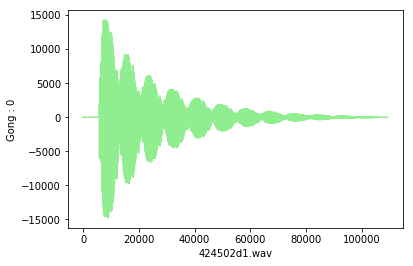

File index num  942
sample_rate is : 44100  samples 122598


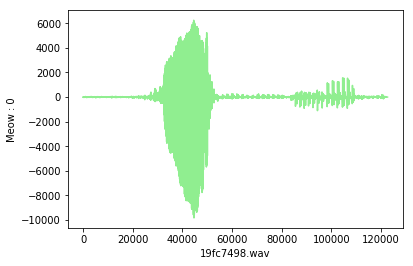

File index num  437
sample_rate is : 44100  samples 78498


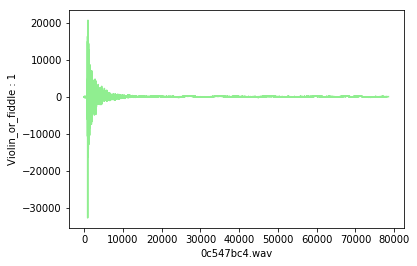

In [4]:
samples=trainFilesList
import random

#l=len(firstTen['fname'])
for i in range(3):
    randFile=random.randint(0,9473)
    wavFile=trainFilesList['fname'][randFile]
    soundType=trainFilesList['label'][randFile]
    verified=trainFilesList['manually_verified'][randFile]
    print('File index num ',randFile)
    seeSound(wavFile,soundType,str(verified))
    playWaveAudio(home+'data/audio_train/'+wavFile,100)


### To visualize all Flute files

sample_rate is : 44100  samples 313110


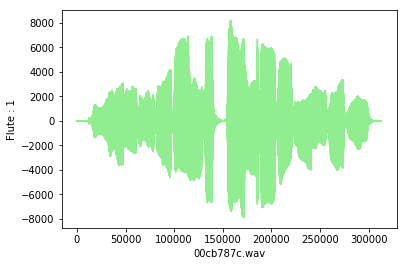

sample_rate is : 44100  samples 220500


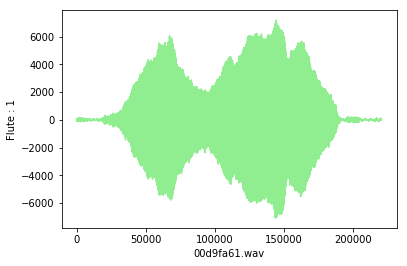

sample_rate is : 44100  samples 331632


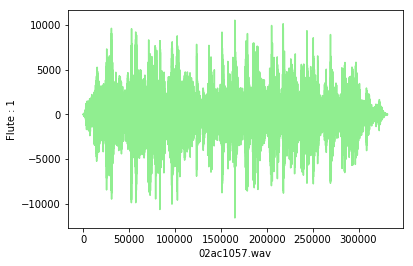

sample_rate is : 44100  samples 301644


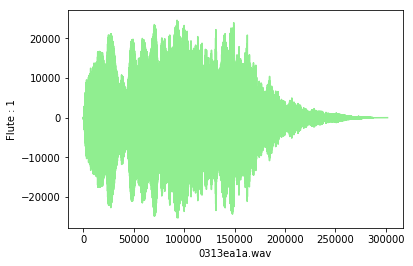

sample_rate is : 44100  samples 24696


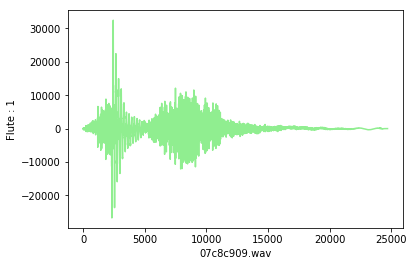

In [5]:

samples=(trainFilesList[trainFilesList['label']=='Flute'])

#l=len(firstTen['fname'])
for i in samples['fname'].head(5):
    seeSound(i,'Flute','1')

Select label,manually_verified,count(*)  from trainFiles group by label,manually_verified

Refer : https://pandas.pydata.org/pandas-docs/stable/comparison_with_sql.html

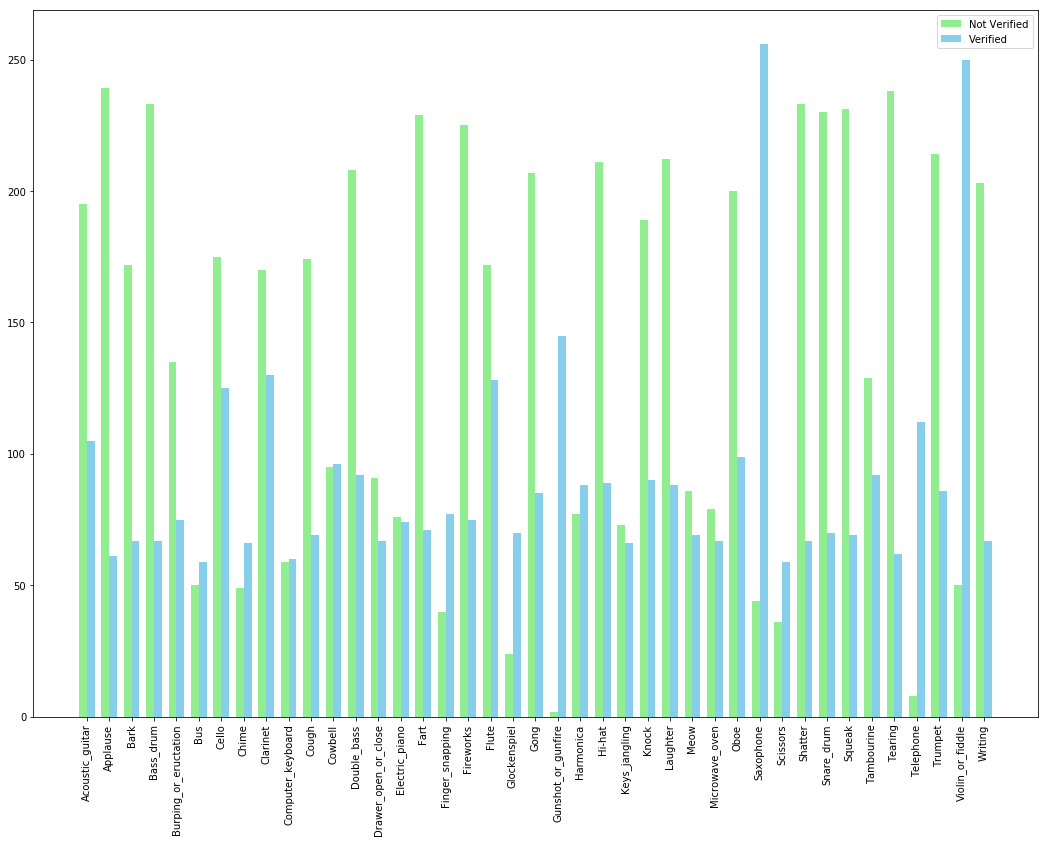

In [6]:

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

gr_for_cols=trainFilesList.groupby('label')
gr=trainFilesList.groupby(['label','manually_verified'])

cols=gr_for_cols.groups.keys()
vals2=gr.size()


verified=[]
not_verified=[]
loop=int(vals2.shape[0])
for i in range(loop):
    if(i % 2==1):
        verified.append(vals2[i])        
    else:
        not_verified.append(vals2[i])

        
ind = np.arange(41)  # the x locations for the groups
width = 0.35  # the width of the bars
        
fig2,ax2=plt.subplots()
rects1 = ax2.bar(ind - width/2, not_verified, width, 
                color='lightgreen', label='Not Verified')
# To refer ax follow 
#https://matplotlib.org/api/axes_api.html#matplotlib.axes.Axes

rects2 = ax2.bar(ind + width/2, verified, width, 
                color='skyblue', label='Verified')
fig2.set_size_inches(18, 13)
plt.xticks(rotation='vertical')
ax2.set_xticks(np.arange(len(cols)))
ax2.set_xticklabels(cols)
ax2.legend()


### How to show player

In [7]:
import IPython.display as ipd
#ipd.Audio('/Users/knnatarasan/workspace/ds/kaggle/atmospace_jungle.wav')

#### Sample Submission format looks like the following

In [8]:
# Load the train document
submissionFilesList = pd.read_csv(home+'doc/sample_submission.csv')
print('Length of submission Files',len(submissionFilesList))

# Success - Display the first record
display(submissionFilesList.head(n=2))

Length of submission Files 9400


,fname,label
0,00063640.wav,Laughter Hi-Hat Flute
1,0013a1db.wav,Laughter Hi-Hat Flute


## Model Building

Important imports

In [9]:
%matplotlib inline  
import gc,pickle,random,librosa,glob,os,pandas as pd,numpy as np,matplotlib.pyplot as plt
from multiprocessing import Pool
#from keras import optimaizers, losses, activations, models
from keras import  losses, activations, models
from keras.callbacks import ModelCheckpoint, EarlyStopping, LearningRateScheduler
from keras.layers import Dense, Input, Dropout, Convolution1D, MaxPool1D, GlobalMaxPool1D, GlobalAveragePooling1D, \
    concatenate
from numpy import random
from PIL import Image
from random import shuffle
from sklearn.model_selection import train_test_split
from tqdm import tqdm

/usr/local/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning:

Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.

Using TensorFlow backend.


In [10]:
input_length = 16000*2

batch_size = 32

def audio_norm(data):
    max_data = np.max(data)
    min_data = np.min(data)
    data = (data-min_data)/(max_data-min_data+0.0001)
    return data-0.5


def load_audio_file(file_path, input_length=input_length):
    data = librosa.core.load(file_path, sr=16000)[0] #, sr=16000

    if len(data)>input_length:
        max_offset = len(data)-input_length
        offset = np.random.randint(max_offset)
        data = data[offset:(input_length+offset)]
        
    else:
      
        if input_length > len(data):
            max_offset = input_length - len(data)

            offset = np.random.randint(max_offset)
        else:
            offset = 0
        
        
        data = np.pad(data, (offset, input_length - len(data) - offset), "constant")
        
        
    data = audio_norm(data)
    return data

In [11]:
train_files=glob.glob(home+'data/audio_train/*.wav')
test_files=glob.glob(home+'data/audio_test/*.wav')
train_labels=pd.read_csv(home+'doc/train.csv')

In [12]:
file_to_label={home+"data/audio_train/"+k:v for k,v in zip(train_labels.fname.values, train_labels.label.values)}

In [134]:
data_base=load_audio_file(train_files[0])

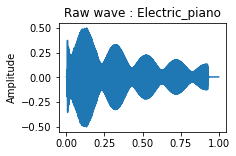

In [15]:
data_base=load_audio_file(train_files[0])
fig=plt.figure(figsize=(3,2))
#file_to_label[train_files[0]]
plt.title('Raw wave : %s' % (file_to_label[train_files[0]]))
plt.ylabel('Amplitude')
plt.plot(np.linspace(0,1,input_length),data_base)
plt.show()


In [16]:
list_labels=sorted(list(set(train_labels.label.values)))
label_to_int={k:v for v,k in enumerate(list_labels)}
int_to_label={v:k for k,v in label_to_int.items()}
file_to_int={k:label_to_int[v] for k,v in file_to_label.items()}

In [17]:
def get_model1():
    nclass = len(list_labels)
    inp = Input(shape=(input_length, 1))
    img_1 = Convolution1D(16, kernel_size=9, activation=activations.relu, padding="valid")(inp)
    img_1 = Convolution1D(16, kernel_size=9, activation=activations.relu, padding="valid")(img_1)
    img_1 = MaxPool1D(pool_size=16)(img_1)
    img_1 = Dropout(rate=0.1)(img_1)
    img_1 = Convolution1D(32, kernel_size=3, activation=activations.relu, padding="valid")(img_1)
    img_1 = Convolution1D(32, kernel_size=3, activation=activations.relu, padding="valid")(img_1)
    img_1 = MaxPool1D(pool_size=4)(img_1)
    img_1 = Dropout(rate=0.1)(img_1)
    img_1 = Convolution1D(32, kernel_size=3, activation=activations.relu, padding="valid")(img_1)
    img_1 = Convolution1D(32, kernel_size=3, activation=activations.relu, padding="valid")(img_1)
    img_1 = MaxPool1D(pool_size=4)(img_1)
    img_1 = Dropout(rate=0.1)(img_1)
    img_1 = Convolution1D(256, kernel_size=3, activation=activations.relu, padding="valid")(img_1)
    img_1 = Convolution1D(256, kernel_size=3, activation=activations.relu, padding="valid")(img_1)
    img_1 = GlobalMaxPool1D()(img_1)
    img_1 = Dropout(rate=0.2)(img_1)

    dense_1 = Dense(64, activation=activations.relu)(img_1)
    dense_1 = Dense(1028, activation=activations.relu)(dense_1)
    dense_1 = Dense(nclass, activation=activations.softmax)(dense_1)

    model = models.Model(inputs=inp, outputs=dense_1)
    opt = optimizers.Adam(0.0001)

    model.compile(optimizer=opt, loss=losses.sparse_categorical_crossentropy, metrics=['acc'])
    model.summary()
    return model

In [101]:
input_length

32000

In [164]:
from keras import optimizers
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv1D, MaxPooling1D
from keras.optimizers import SGD

model = Sequential()
model.add(Conv1D(64, 1, activation='relu', input_shape=(input_length, )))
model.add(Conv1D(64, 1, activation='relu'))
model.add(MaxPooling1D(1))
model.add(Conv1D(128, 1, activation='relu'))
model.add(Conv1D(128, 1, activation='relu'))
model.add(GlobalAveragePooling1D())
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])


ValueError: Input 0 is incompatible with layer conv1d_19: expected ndim=3, found ndim=2

In [140]:
print(len(train_files))

9473


In [156]:
# print(train_files[:5])
# # test_files
# print(train_labels['label'][0])
pop=len(train_files)
input_length=16000

y_train=np.empty([pop-2000])
X_train=np.empty([pop-2000, input_length])
y_test=np.empty([2000])
X_test=np.empty([2000, input_length])


for i in range(10):
# for i in range(len(train_files)):
    data = load_audio_file(train_files[i],input_length)
    X_train[i]=data[0]

y_train=train_labels['label'][0:(pop-2000)]
y_test=train_labels['label'][(pop-2000):pop]


In [159]:
print(X_train.shape)
print(y_train.shape)
print(y_train[0:10])

(7473, 16000)
(7473,)
0                Hi-hat
1             Saxophone
2               Trumpet
3          Glockenspiel
4                 Cello
5                 Cello
6                 Knock
7    Gunshot_or_gunfire
8              Clarinet
9     Computer_keyboard
Name: label, dtype: object


In [162]:
model.fit(X_train, y_train, batch_size=32, epochs=10)
score = model.evaluate(X_test, y_test, batch_size=32)

ValueError: Error when checking input: expected conv1d_14_input to have 3 dimensions, but got array with shape (7473, 16000)

In [111]:
def chunker(seq,size):
    print(len(seq))
    return (seq[pos:pos+size] for pos in range(0,len(seq),size))

In [112]:
def train_generator(list_files, batch_size=batch_size):
    while True:
        shuffle(list_files)
        for batch_files in chunker(list_files, size=batch_size):
            batch_data = [load_audio_file(fpath) for fpath in batch_files]
            batch_data = np.array(batch_data)[:,:,np.newaxis]
            batch_labels = [file_to_int[fpath] for fpath in batch_files]
            batch_labels = np.array(batch_labels)
            
            yield batch_data, batch_labels

In [116]:
tr_files, val_files = train_test_split(train_files, test_size=0.1)
# tr_files, val_files = train_test_split(train_files, test_size=0.1)

In [23]:
# model.fit_generator(train_generator(tr_files), steps_per_epoch=len(tr_files)//batch_size, epochs=2,
#                     validation_data=train_generator(val_files), validation_steps=len(val_files)//batch_size,
#                    use_multiprocessing=True, workers=8, max_queue_size=20)

model.fit_generator(train_generator(tr_files), steps_per_epoch=2, epochs=2,
                    validation_data=train_generator(val_files), validation_steps=len(val_files)//batch_size,
                   use_multiprocessing=True, workers=8, max_queue_size=20)




/usr/local/lib/python3.6/site-packages/keras/engine/training.py:2087: UserWarning:

Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.



8525
8525
8525
8525
8525
8525
8525
8525
Epoch 1/2


ValueError: Error when checking target: expected dense_3 to have 3 dimensions, but got array with shape (32, 1)

In [ ]:
model.save_weights("baseline_cnn.h5")

In [37]:
list_preds=[]

In [38]:
for batch_files in tqdm(chunker(test_files, size=batch_size), total=len(test_files)//batch_size ):
    batch_data = [load_audio_file(fpath) for fpath in batch_files]
    batch_data = np.array(batch_data)[:,:,np.newaxis]
    preds = model.predict(batch_data).tolist()
    list_preds += preds

  0%|          | 0/293 [00:00<?, ?it/s]

9400


NameError: name 'model' is not defined

In [ ]:
array_preds = np.array(list_preds)

In [ ]:
list_labels = np.array(list_labels)

In [ ]:
top_3 = list_labels[np.argsort(-array_preds, axis=1)[:, :3]] #https://www.kaggle.com/inversion/freesound-starter-kernel
pred_labels = [' '.join(list(x)) for x in top_3]

In [ ]:
df = pd.DataFrame(test_files, columns=["fname"])
df['label'] = pred_labels

In [ ]:
df['fname'] = df.fname.apply(lambda x: x.split("/")[-1])

In [ ]:
df.to_csv("baseline.csv", index=False)

## How MAP@K works

In [3]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

#from subprocess import check_output

import ml_metrics as metrics

In [17]:
actual = [1]

predicted = [1,2,3,4,5]

pos=1
print('Answer=',actual,'predicted=',predicted)
print('AP@5 =',metrics.apk(actual,predicted,5) )

predicted = [2,1,3,4,5]
print('Answer=',actual,'predicted=',predicted)
print('AP@5 =',metrics.apk(actual,predicted,5) )

predicted = [3,2,1,4,5]
print('Answer=',actual,'predicted=',predicted)
print('AP@5 =',metrics.apk(actual,predicted,5) )

predicted = [4,2,3,1,5]
print('Answer=',actual,'predicted=',predicted)
print('AP@5 =',metrics.apk(actual,predicted,5) )

predicted = [4,2,3,5,1]
print('Answer=',actual,'predicted=',predicted)
print('AP@5 =',metrics.apk(actual,predicted,5) )

Answer= [1] predicted= [1, 2, 3, 4, 5]
AP@5 = 1.0
Answer= [1] predicted= [2, 1, 3, 4, 5]
AP@5 = 0.5
Answer= [1] predicted= [3, 2, 1, 4, 5]
AP@5 = 0.3333333333333333
Answer= [1] predicted= [4, 2, 3, 1, 5]
AP@5 = 0.25
Answer= [1] predicted= [4, 2, 3, 5, 1]
AP@5 = 0.2
